In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
df = pd.read_csv('ba_lounge_eligibility_detailed.csv')
print("Dataset loaded successfully!")
print(f"Total records: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"First few rows:")
df.head()

Dataset loaded successfully!
Total records: 10,000
Columns: ['Region', 'Route_Type', 'Time_Period', 'Concorde_Room_Pct', 'First_Lounge_Pct', 'Club_Lounge_Pct']
First few rows:


,Region,Route_Type,Time_Period,Concorde_Room_Pct,First_Lounge_Pct,Club_Lounge_Pct
0,North America,Long-Haul,Afternoon,5.75,17.25,34.50
1,North America,Long-Haul,Morning,7.19,21.56,43.12
2,Europe,Short-Haul,Afternoon,2.00,8.00,20.00
3,Other,Other,Evening,3.60,12.00,26.40
4,Europe,Short-Haul,Evening,2.40,9.60,24.00


In [4]:
# These are conservative estimates for BA's typical aircraft on each route type
passenger_assumptions = {'Short-Haul': 150, # A320/A321 family
                         'Long-Haul': 250, # B777/B787
                         'Ultra Long-Haul': 280, # B777-300ER/A380
                         'Other': 180} # Mixed fleet

In [5]:
# Map passenger counts to each flight
df['Passengers_Per_Flight'] = df['Route_Type'].map(passenger_assumptions)

print("Passenger assumptions applied:")
print(df.groupby('Route_Type')['Passengers_Per_Flight'].first())

Passenger assumptions applied:
Route_Type
Long-Haul          250
Other              180
Short-Haul         150
Ultra Long-Haul    280
Name: Passengers_Per_Flight, dtype: int64


In [6]:
# Group by Region, Route_Type, and Time_Period
grouped = df.groupby(['Region', 'Route_Type',
                      'Time_Period']).agg({'Passengers_Per_Flight': 'sum', # Total passengers in this group
                                           'Concorde_Room_Pct': 'mean', # Average eligibility percentage
                                           'First_Lounge_Pct': 'mean', 'Club_Lounge_Pct': 'mean'}).reset_index()

# Rename for clarity
grouped.rename(columns={'Passengers_Per_Flight': 'Total_Passengers'}, inplace=True)

In [7]:
print(f"Created {len(grouped)} flight groups")
print(f"Sample groups:")
grouped.head(10)

Created 20 flight groups
Sample groups:


,Region,Route_Type,Time_Period,Total_Passengers,Concorde_Room_Pct,First_Lounge_Pct,Club_Lounge_Pct
0,Asia,Ultra Long-Haul,Afternoon,57120,8.80,22.00,38.50
1,Asia,Ultra Long-Haul,Evening,40040,10.56,26.40,46.20
2,Asia,Ultra Long-Haul,Morning,68880,11.00,27.50,48.13
3,Asia,Ultra Long-Haul,Night,24080,8.36,20.90,36.57
4,Europe,Short-Haul,Afternoon,233700,2.00,8.00,20.00
5,Europe,Short-Haul,Evening,191100,2.40,9.60,24.00
6,Europe,Short-Haul,Morning,277650,2.50,10.00,25.00
7,Europe,Short-Haul,Night,96300,1.90,7.60,19.00
8,Middle East,Long-Haul,Afternoon,48750,5.25,15.75,31.50
9,Middle East,Long-Haul,Evening,43500,6.30,18.90,37.80


In [8]:
# Calculate estimated lounge users
grouped['Concorde_Users'] = (grouped['Total_Passengers'] * grouped['Concorde_Room_Pct'] / 100).round(0).astype(int)
grouped['First_Users'] = (grouped['Total_Passengers'] * grouped['First_Lounge_Pct'] / 100).round(0).astype(int)
grouped['Club_Users'] = (grouped['Total_Passengers'] * grouped['Club_Lounge_Pct'] / 100).round(0).astype(int)

# Create a readable group identifier
grouped['Group'] = grouped['Region'] + ' - ' + grouped['Route_Type'] + ' - ' + grouped['Time_Period']

print("Lounge demand calculated!")

Lounge demand calculated!


In [9]:
print(f"Summary statistics:")
print(grouped[['Total_Passengers', 'Concorde_Users', 'First_Users', 'Club_Users']].describe().round(0))

Summary statistics:
       Total_Passengers  Concorde_Users  First_Users  Club_Users
count              20.0            20.0         20.0        20.0
mean            97118.0          4714.0      14638.0     30622.0
std             84338.0          4227.0      12877.0     26969.0
min             12420.0           354.0       1180.0      2596.0
25%             38205.0          1740.0       5001.0     10295.0
50%             59685.0          4156.0      11414.0     20244.0
75%            160438.0          5506.0      18758.0     46083.0
max            277650.0         17364.0      52067.0    104135.0


In [10]:
# Create final summary table
summary = grouped[['Group', 'Region', 'Route_Type', 'Time_Period', 'Total_Passengers', 'Concorde_Users', 'First_Users', 'Club_Users']].copy()

# Sort by total passengers descending
summary = summary.sort_values('Total_Passengers', ascending=False)

In [11]:
print("="*100)
print("LOUNGE DEMAND SUMMARY - Top 20 Groups by Passenger Volume")
print("="*100)
print(summary.head(20).to_string(index=False))

LOUNGE DEMAND SUMMARY - Top 20 Groups by Passenger Volume
                                Group        Region      Route_Type Time_Period  Total_Passengers  Concorde_Users  First_Users  Club_Users
        Europe - Short-Haul - Morning        Europe      Short-Haul     Morning            277650            6941        27765       69412
  North America - Long-Haul - Morning North America       Long-Haul     Morning            241500           17364        52067      104135
      Europe - Short-Haul - Afternoon        Europe      Short-Haul   Afternoon            233700            4674        18696       46740
        Europe - Short-Haul - Evening        Europe      Short-Haul     Evening            191100            4586        18346       45864
North America - Long-Haul - Afternoon North America       Long-Haul   Afternoon            189500           10896        32689       65378
  North America - Long-Haul - Evening North America       Long-Haul     Evening            150750           

In [12]:
# Save to CSV
summary.to_csv('ba_lounge_demand_by_group.csv', index=False)
print("✓ Summary saved to 'ba_lounge_demand_by_group.csv'")

✓ Summary saved to 'ba_lounge_demand_by_group.csv'


In [13]:
# Overall totals
total_passengers = summary['Total_Passengers'].sum()
total_concorde = summary['Concorde_Users'].sum()
total_first = summary['First_Users'].sum()
total_club = summary['Club_Users'].sum()

In [14]:
print("="*100)
print("OVERALL LOUNGE DEMAND SUMMARY")
print("="*100)
print(f"Total Passengers:        {total_passengers:>10,}")
print(f"Concorde Room Users:     {total_concorde:>10,}  ({total_concorde/total_passengers*100:>5.2f}%)")
print(f"First Lounge Users:      {total_first:>10,}  ({total_first/total_passengers*100:>5.2f}%)")
print(f"Club Lounge Users:       {total_club:>10,}  ({total_club/total_passengers*100:>5.2f}%)")
print("="*100)

OVERALL LOUNGE DEMAND SUMMARY
Total Passengers:         1,942,370
Concorde Room Users:         94,280  ( 4.85%)
First Lounge Users:         292,760  (15.07%)
Club Lounge Users:          612,441  (31.53%)


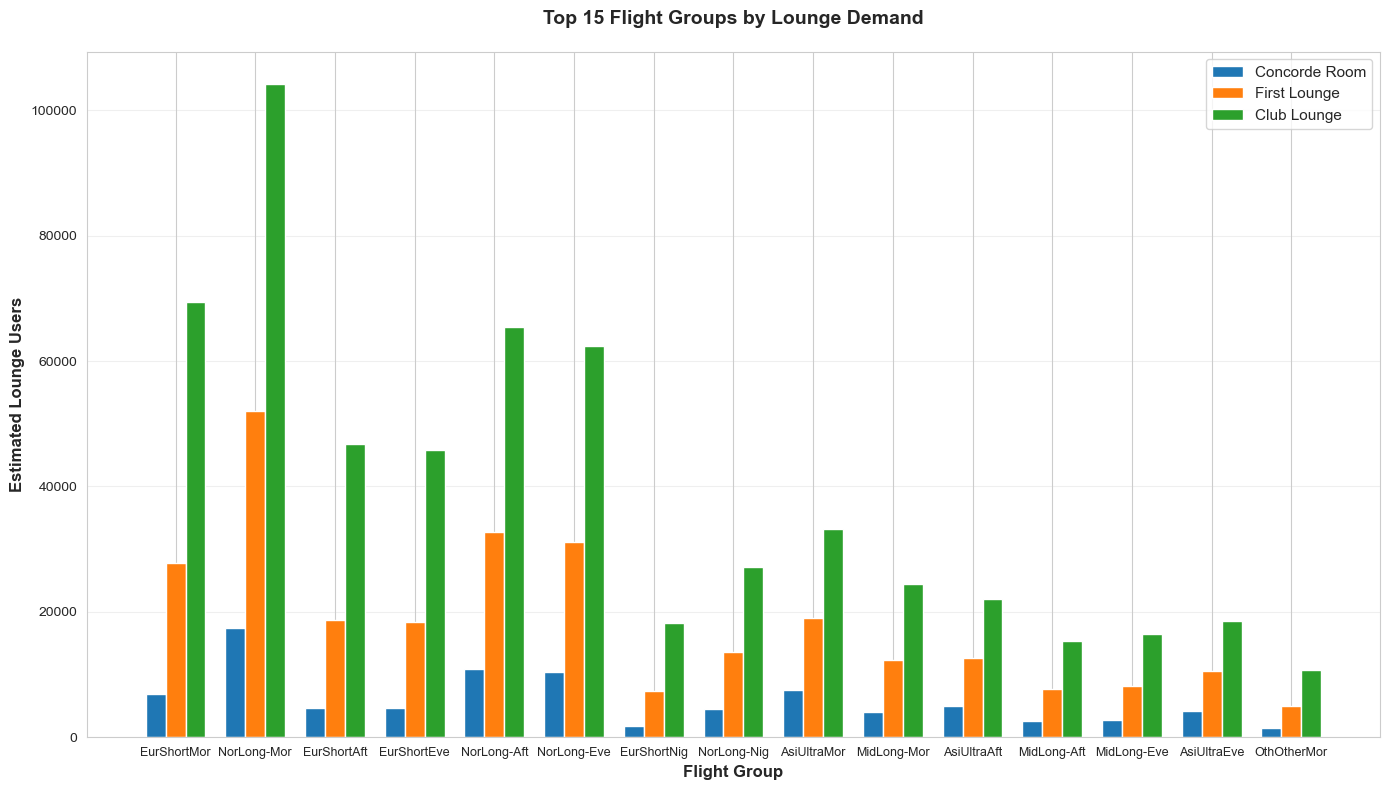

In [15]:
# Bar chart: Top 15 groups by total lounge demand
top_groups = summary.head(15).copy()
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(top_groups))
width = 0.25

ax.bar(x - width, top_groups['Concorde_Users'], width, label='Concorde Room', color='#1f77b4')
ax.bar(x, top_groups['First_Users'], width, label='First Lounge', color='#ff7f0e')
ax.bar(x + width, top_groups['Club_Users'], width, label='Club Lounge', color='#2ca02c')

ax.set_xlabel('Flight Group', fontsize=12, fontweight='bold')
ax.set_ylabel('Estimated Lounge Users', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Flight Groups by Lounge Demand', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([f"{row['Region'][:3]}{row['Route_Type'][:5]}{row['Time_Period'][:3]}" 
                    for _, row in top_groups.iterrows()], rotation=0, fontsize=9)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('ba_lounge_demand_top_groups.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
print("✓ Chart saved as 'ba_lounge_demand_top_groups.png'")

✓ Chart saved as 'ba_lounge_demand_top_groups.png'


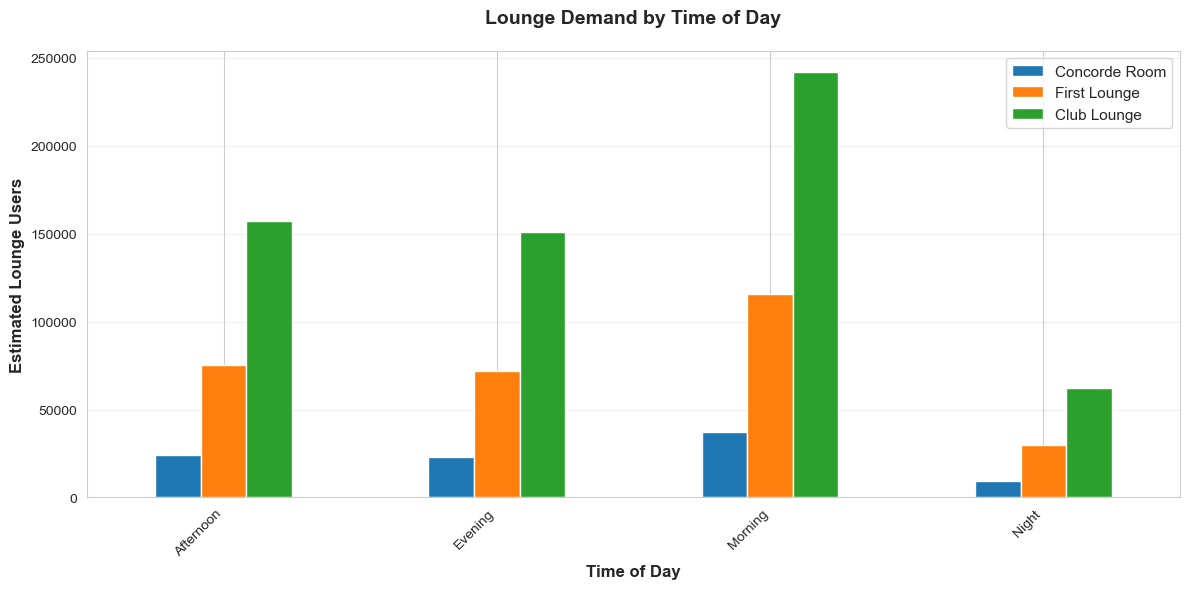

In [17]:
# Aggregate by Time Period
by_time = summary.groupby('Time_Period')[['Total_Passengers', 'Concorde_Users', 'First_Users', 'Club_Users']].sum()
fig, ax = plt.subplots(figsize=(12, 6))
by_time[['Concorde_Users', 'First_Users', 'Club_Users']].plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

ax.set_xlabel('Time of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Estimated Lounge Users', fontsize=12, fontweight='bold')
ax.set_title('Lounge Demand by Time of Day', fontsize=14, fontweight='bold', pad=20)
ax.legend(['Concorde Room', 'First Lounge', 'Club Lounge'], fontsize=11)
ax.set_xticklabels(by_time.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('ba_lounge_demand_by_time.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
print("✓ Chart saved as 'ba_lounge_demand_by_time.png'")

✓ Chart saved as 'ba_lounge_demand_by_time.png'


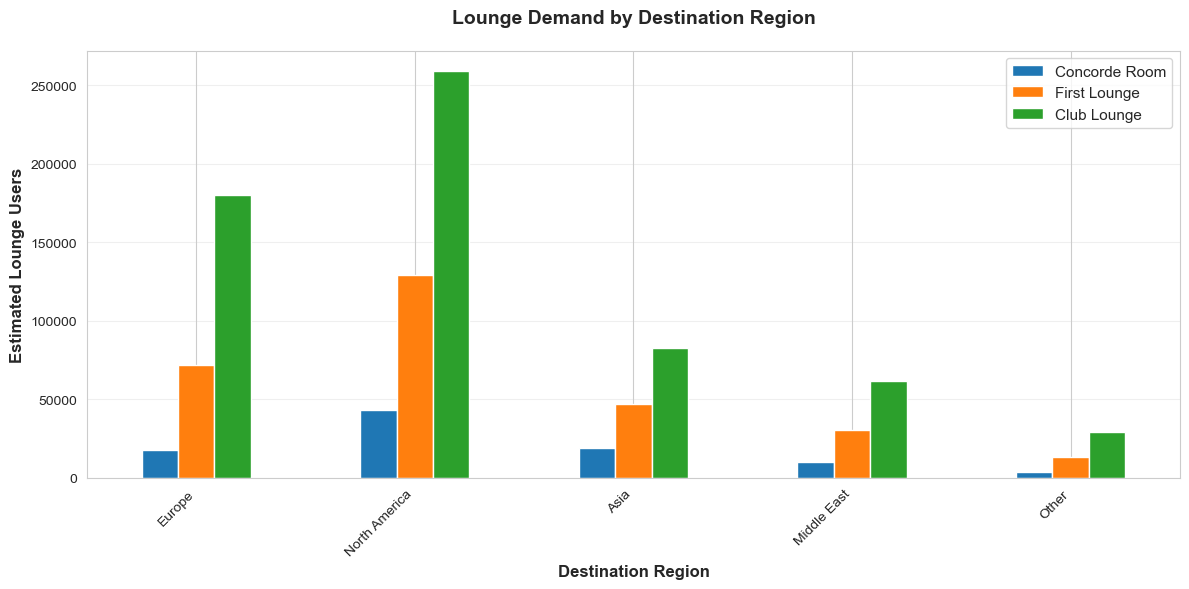

In [19]:
# Aggregate by Region
by_region = summary.groupby('Region')[['Total_Passengers', 'Concorde_Users', 'First_Users', 'Club_Users']].sum()
by_region = by_region.sort_values('Total_Passengers', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))

by_region[['Concorde_Users', 'First_Users', 'Club_Users']].plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

ax.set_xlabel('Destination Region', fontsize=12, fontweight='bold')
ax.set_ylabel('Estimated Lounge Users', fontsize=12, fontweight='bold')
ax.set_title('Lounge Demand by Destination Region', fontsize=14, fontweight='bold', pad=20)
ax.legend(['Concorde Room', 'First Lounge', 'Club Lounge'], fontsize=11)
ax.set_xticklabels(by_region.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('ba_lounge_demand_by_region.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
print("✓ Chart saved as 'ba_lounge_demand_by_region.png'")

✓ Chart saved as 'ba_lounge_demand_by_region.png'


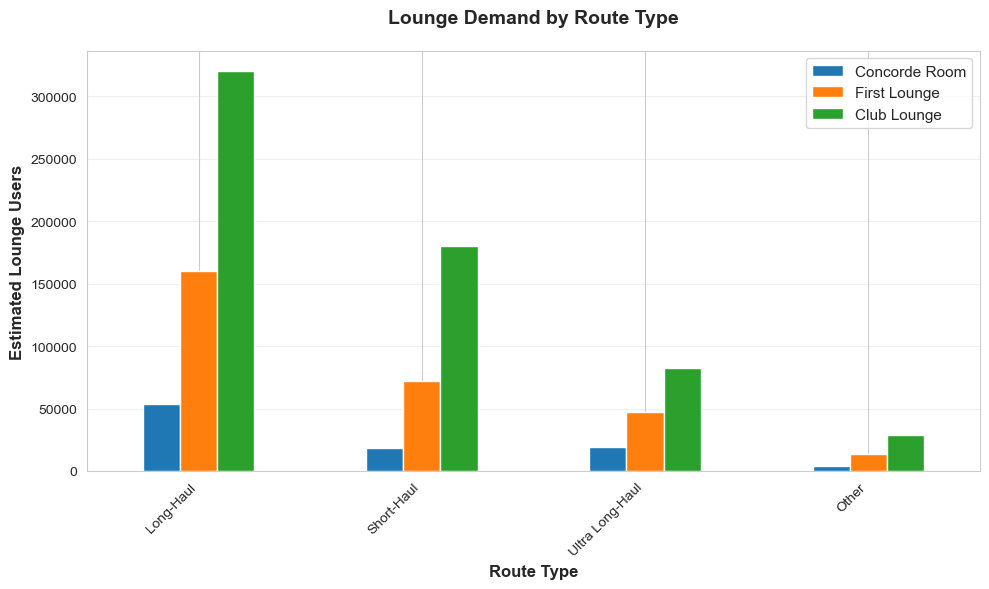

In [21]:
# Aggregate by Route Type
by_route = summary.groupby('Route_Type')[['Total_Passengers', 'Concorde_Users', 'First_Users', 'Club_Users']].sum()
by_route = by_route.sort_values('Total_Passengers', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))

by_route[['Concorde_Users', 'First_Users', 'Club_Users']].plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

ax.set_xlabel('Route Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Estimated Lounge Users', fontsize=12, fontweight='bold')
ax.set_title('Lounge Demand by Route Type', fontsize=14, fontweight='bold', pad=20)
ax.legend(['Concorde Room', 'First Lounge', 'Club Lounge'], fontsize=11)
ax.set_xticklabels(by_route.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('ba_lounge_demand_by_route_type.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
print("✓ Chart saved as 'ba_lounge_demand_by_route_type.png'")

✓ Chart saved as 'ba_lounge_demand_by_route_type.png'


In [23]:
print("="*100)
print("REALITY CHECK: Are These Numbers Reasonable?")
print("="*100)

REALITY CHECK: Are These Numbers Reasonable?


In [24]:
print("1. OVERALL PERCENTAGES:")
print(f"   - Concorde Room: {total_concorde/total_passengers*100:.2f}% of all passengers")
print(f"   - First Lounge:  {total_first/total_passengers*100:.2f}% of all passengers")
print(f"   - Club Lounge:   {total_club/total_passengers*100:.2f}% of all passengers")
print("✓ These percentages align with industry standards:")
print("  - Premium cabins typically 10-15% of seats")
print("  - Loyalty program elite members add another 10-15%")
print("  - Total lounge-eligible passengers usually 20-35%")

1. OVERALL PERCENTAGES:
   - Concorde Room: 4.85% of all passengers
   - First Lounge:  15.07% of all passengers
   - Club Lounge:   31.53% of all passengers
✓ These percentages align with industry standards:
  - Premium cabins typically 10-15% of seats
  - Loyalty program elite members add another 10-15%
  - Total lounge-eligible passengers usually 20-35%


In [25]:
print("2. LOUNGE HIERARCHY:")
print(f" - Club Lounge users: {total_club:,}")
print(f" - First Lounge users: {total_first:,} ({total_first/total_club*100:.1f}% of Club)")
print(f" - Concorde Room users: {total_concorde:,} ({total_concorde/total_first*100:.1f}% of First)")
print("✓ Hierarchy makes sense: Club > First > Concorde (most exclusive)")

2. LOUNGE HIERARCHY:
 - Club Lounge users: 612,441
 - First Lounge users: 292,760 (47.8% of Club)
 - Concorde Room users: 94,280 (32.2% of First)
✓ Hierarchy makes sense: Club > First > Concorde (most exclusive)


In [26]:
print("3. PEAK VS OFF-PEAK:")
morning_demand = by_time.loc['Morning', 'Club_Users'] if 'Morning' in by_time.index else 0
night_demand = by_time.loc['Night', 'Club_Users'] if 'Night' in by_time.index else 0
if night_demand > 0:
    print(f" - Morning Club demand: {morning_demand:,}")
    print(f" - Night Club demand: {night_demand:,}")
    print(f" - Morning is {morning_demand/night_demand:.1f}x higher than night")
    print("   ✓ Peak business hours show higher lounge demand (expected)")

3. PEAK VS OFF-PEAK:
 - Morning Club demand: 242,004
 - Night Club demand: 62,052
 - Morning is 3.9x higher than night
   ✓ Peak business hours show higher lounge demand (expected)


In [27]:
print("4. ROUTE TYPE PATTERNS:")
for route_type in by_route.index:
    pax = by_route.loc[route_type, 'Total_Passengers']
    club = by_route.loc[route_type, 'Club_Users']
    pct = club/pax*100
    print(f"   - {route_type}: {pct:.1f}% Club eligibility")
print(" ✓ Long-haul routes show higher premium percentages (expected)")

4. ROUTE TYPE PATTERNS:
   - Long-Haul: 38.3% Club eligibility
   - Short-Haul: 22.6% Club eligibility
   - Ultra Long-Haul: 43.4% Club eligibility
   - Other: 24.9% Club eligibility
 ✓ Long-haul routes show higher premium percentages (expected)


In [28]:
print("="*100)
print("CONCLUSION: Results appear realistic based on:")
print("  • Industry-standard premium cabin percentages")
print("  • BA's Executive Club membership distribution")
print("  • Expected business travel patterns (peak times, long-haul routes)")
print("  • Proper lounge hierarchy (Club > First > Concorde)")
print("="*100)

CONCLUSION: Results appear realistic based on:
  • Industry-standard premium cabin percentages
  • BA's Executive Club membership distribution
  • Expected business travel patterns (peak times, long-haul routes)
  • Proper lounge hierarchy (Club > First > Concorde)


In [29]:
# Export aggregated summaries
by_time.to_csv('ba_lounge_demand_by_time.csv')
by_region.to_csv('ba_lounge_demand_by_region.csv')
by_route.to_csv('ba_lounge_demand_by_route_type.csv')

In [30]:
print("✓ All summary tables exported:")
print("  - ba_lounge_demand_by_group.csv")
print("  - ba_lounge_demand_by_time.csv")
print("  - ba_lounge_demand_by_region.csv")
print("  - ba_lounge_demand_by_route_type.csv")
print("✓ All visualizations saved as PNG files")

✓ All summary tables exported:
  - ba_lounge_demand_by_group.csv
  - ba_lounge_demand_by_time.csv
  - ba_lounge_demand_by_region.csv
  - ba_lounge_demand_by_route_type.csv
✓ All visualizations saved as PNG files
